In [1]:
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

In [2]:
# Directory where your Excel files are located
#directory = r'C:\Users\IRAXA11\Documents\Research\Recovery Rates Project'
#directory = r'C:\Users\angel\Documents\Economics\Research\Recovery Rates Project\Data\Italian_Dataset'
directory = r'C:\Users\Usuario\Desktop\Lucas\Repositories\Expected_recovery_rates\Data'

### Preamble

In [3]:
# define function to interpolate yields that have NA observations
def interpolate_linear(i, col, next_col_left, next_col_right, it_yield_df):
    # Closest maturities to the left and right:
    x1 = it_yield_df.columns[next_col_left]
    x2 = it_yield_df.columns[next_col_right]
    y1 = it_yield_df.at[i, x1]
    y2 = it_yield_df.at[i, x2]
    # Convert the column names to integers taking away the 'M' part:
    x = int(col[:-1])
    x1 = int(x1[:-1])
    x2 = int(x2[:-1])
    # Weighted average:

    return (y1 * (x2 - x) + y2 * (x - x1)) / (x2 - x1)

### Loading & Merging Italian Yields 

In [4]:
# load data for the yield curves 
it_yield_3y = pd.read_excel('IT_Yields_until3Y.xlsx')
it_yield_4y_20y = pd.read_excel('IT_Yields_4_to_20Y.xlsx')
it_yield_30y_50y = pd.read_excel('IT_Yields_30_to_50Y.xlsx')

In [5]:
# rename and drop useless columns
it_yield_3y = it_yield_3y.drop(columns=['I40 EUR Italy Sovereign Curve 6M (Mid YTM) - I40 EUR Italy Sovereign Curve 3M (Mid YTM)',
       'I40 EUR Italy Sovereign Curve 1Y (Mid YTM) - I40 EUR Italy Sovereign Curve 3M (Mid YTM)',
       'I40 EUR Italy Sovereign Curve 2Y (Mid YTM) - I40 EUR Italy Sovereign Curve 3M (Mid YTM)',
       'I40 EUR Italy Sovereign Curve 3Y (Mid YTM) - I40 EUR Italy Sovereign Curve 3M (Mid YTM)'])

it_yield_3y = it_yield_3y.rename(columns={ 'I40 EUR Italy Sovereign Curve 3M(BOTS 0 05/31/24 <Corp>) (Mid YTM)':'3M',
                         'I40 EUR Italy Sovereign Curve 6M(BOTS 0 07/31/24 <Corp>) (Mid YTM)':'6M',  
                         'I40 EUR Italy Sovereign Curve 1Y(BOTS 0 01/14/25 <Corp>) (Mid YTM)':'12M',
                         'I40 EUR Italy Sovereign Curve 2Y(BTPS 3.6 09/29/25 <Corp>) (Mid YTM)': '24M',
                         'I40 EUR Italy Sovereign Curve 3Y(BTPS 3.85 09/15/26 <Corp>) (Mid YTM)': '36M'})

it_yield_3y = it_yield_3y[['Date','3M', '6M', '12M', '24M', '36M']]

In [6]:
# rename and drop useless columns
it_yield_4y_20y = it_yield_4y_20y.drop(columns=['I40 EUR Italy Sovereign Curve 5Y (Mid YTM) - I40 EUR Italy Sovereign Curve 4Y (Mid YTM)',
       'I40 EUR Italy Sovereign Curve 10Y (Mid YTM) - I40 EUR Italy Sovereign Curve 4Y (Mid YTM)',
       'I40 EUR Italy Sovereign Curve 15Y (Mid YTM) - I40 EUR Italy Sovereign Curve 4Y (Mid YTM)',
       'I40 EUR Italy Sovereign Curve 20Y (Mid YTM) - I40 EUR Italy Sovereign Curve 4Y (Mid YTM)'])

it_yield_4y_20y = it_yield_4y_20y.rename(columns={'I40 EUR Italy Sovereign Curve 4Y(BTPS 2 02/01/28 <Corp>) (Mid YTM)':'48M', 
                         'I40 EUR Italy Sovereign Curve 5Y(BTPS 4.1 02/01/29 <Corp>) (Mid YTM)':'60M', 
                         'I40 EUR Italy Sovereign Curve 10Y(BTPS 4.2 03/01/34 <Corp>) (Mid YTM)':'120M',
                         'I40 EUR Italy Sovereign Curve 15Y(BTPS 3 ¼ 03/01/38 <Corp>) (Mid YTM)': '180M',
                         'I40 EUR Italy Sovereign Curve 20Y(BTPS 4.45 09/01/43 <Corp>) (Mid YTM)': '240M'})

In [7]:
# rename and drop useless columns
it_yield_30y_50y = it_yield_30y_50y.drop(columns=['I40 EUR Italy Sovereign Curve 50Y (Mid YTM) - I40 EUR Italy Sovereign Curve 30Y (Mid YTM)'])

it_yield_30y_50y = it_yield_30y_50y.rename(columns={'I40 EUR Italy Sovereign Curve 30Y(BTPS 4 ½ 10/01/53 <Corp>) (Mid YTM)':'360M', 
                         'I40 EUR Italy Sovereign Curve 50Y(BTPS 2.15 03/01/2072 <Corp>) (Mid YTM)':'600M'})

In [8]:
# temporary merge 
temp = pd.merge(it_yield_4y_20y, it_yield_30y_50y, on='Date')

In [9]:
# merge to create the yield dataset  
it_yield_df = pd.merge(it_yield_3y, temp, on='Date')

In [10]:
# interpolate Italian yields to get rid of the NA values for valid horizons of the curve
for col in it_yield_df.columns[2:-1]:

    for i in range(len(it_yield_df[col])):

        if pd.isnull(it_yield_df.at[i, col]):

            next_col_right = it_yield_df.columns.get_loc(col) + 1
            next_col_left = it_yield_df.columns.get_loc(col) - 1
            
            # Find the next non-null value column to the right of the missing value:
            while next_col_right <= it_yield_df.columns.get_loc('600M'):
                if pd.isnull(it_yield_df.at[i, it_yield_df.columns[next_col_right]]):
                    next_col_right = it_yield_df.columns.get_loc(it_yield_df.columns[next_col_right]) + 1
                    continue
                else:
                    break

            # Find the next non-null value column to the left of the missing value:
            while next_col_left >= it_yield_df.columns.get_loc('3M'):
                if pd.isnull(it_yield_df.at[i, it_yield_df.columns[next_col_left]]):
                    next_col_left = it_yield_df.columns.get_loc(it_yield_df.columns[next_col_left]) - 1
                    continue
                else:
                    break

            # If values for interpolation are missing, skip:   
            if next_col_left < it_yield_df.columns.get_loc('3M') or next_col_right > it_yield_df.columns.get_loc('600M'):
                continue
            
            # If we can interpolate, do it:
            else:
                it_yield_df.at[i, col] = interpolate_linear(i, col, next_col_left, next_col_right, it_yield_df)

In [11]:
# export to excel:
it_yield_df.to_excel('it_yield_df.xlsx')

### Loading & Merging German Yields 

In [12]:
# load data for the yield curves 
ger_yield_2y = pd.read_excel('Germany_yields_3M_to_2Y.xlsx')
ger_yield_3y_15y = pd.read_excel('Germany_yields_3Y_to_15Y.xlsx')
ger_yield_20y_30y = pd.read_excel('Germany_yields_20Y_to_30Y.xlsx')

In [13]:
# rename and drop useless columns
ger_yield_2y = ger_yield_2y.drop(columns=['I16 EUR German Sovereign Curve 1Y (Mid YTM) - I16 EUR German Sovereign Curve 3M (Mid YTM)',
       'I16 EUR German Sovereign Curve 6M (Mid YTM) - I16 EUR German Sovereign Curve 3M (Mid YTM)',
       'I16 EUR German Sovereign Curve 9M (Mid YTM) - I16 EUR German Sovereign Curve 3M (Mid YTM)',
       'I16 EUR German Sovereign Curve 2Y (Mid YTM) - I16 EUR German Sovereign Curve 3M (Mid YTM)'])

ger_yield_2y = ger_yield_2y.rename(columns={ 'I16 EUR German Sovereign Curve 3M(BUBILL 0 05/15/24 <Corp>) (Mid YTM)':'3M',
                         'I16 EUR German Sovereign Curve 6M(BUBILL 0 08/21/24 <Corp>) (Mid YTM)':'6M',  
                         'I16 EUR German Sovereign Curve 9M(BUBILL 0 10/16/24 <Corp>) (Mid YTM)':'9M',
                         'I16 EUR German Sovereign Curve 1Y(BUBILL 0 01/15/25 <Corp>) (Mid YTM)': '12M',
                         'I16 EUR German Sovereign Curve 2Y(BKO 2 ½ 03/19/26 <Corp>) (Mid YTM)': '24M'})
ger_yield_2y = ger_yield_2y[['Date', '3M', '6M', '9M', '12M', '24M']]

In [14]:
# rename and drop useless columns
ger_yield_3y_15y = ger_yield_3y_15y.drop(columns=['I16 EUR German Sovereign Curve 4Y (Mid YTM) - I16 EUR German Sovereign Curve 3Y (Mid YTM)',
       'I16 EUR German Sovereign Curve 5Y (Mid YTM) - I16 EUR German Sovereign Curve 3Y (Mid YTM)',
       'I16 EUR German Sovereign Curve 10Y (Mid YTM) - I16 EUR German Sovereign Curve 3Y (Mid YTM)',
       'I16 EUR German Sovereign Curve 15Y (Mid YTM) - I16 EUR German Sovereign Curve 3Y (Mid YTM)'])

ger_yield_3y_15y = ger_yield_3y_15y.rename(columns={ 'I16 EUR German Sovereign Curve 3Y(OBL 0 04/16/27 #185 <Corp>) (Mid YTM)':'36M',
                         'I16 EUR German Sovereign Curve 4Y(OBL 2.2 04/13/28 #187 <Corp>) (Mid YTM)':'48M',  
                         'I16 EUR German Sovereign Curve 5Y(OBL 2.1 04/12/29 #189 <Corp>) (Mid YTM)':'60M',
                         'I16 EUR German Sovereign Curve 10Y(DBR 2.2 02/15/34 <Corp>) (Mid YTM)': '120M',
                         'I16 EUR German Sovereign Curve 15Y(DBR 1 05/15/38 <Corp>) (Mid YTM)': '180M'})


In [15]:
# rename and drop useless columns
ger_yield_20y_30y = ger_yield_20y_30y.drop(columns=['I16 EUR German Sovereign Curve 30Y (Mid YTM) - I16 EUR German Sovereign Curve 20Y (Mid YTM)'])

ger_yield_20y_30y = ger_yield_20y_30y.rename(columns={ 'I16 EUR German Sovereign Curve 20Y(DBR 3 ¼ 07/04/42 <Corp>) (Mid YTM)':'240M',
                         'I16 EUR German Sovereign Curve 30Y(DBR 1.8 08/15/53 <Corp>) (Mid YTM)':'360M'})


In [16]:
# temporary merge 
temp = pd.merge(ger_yield_3y_15y, ger_yield_20y_30y, on='Date')

In [17]:
# merge to create the yield dataset  
ger_yield_df = pd.merge(ger_yield_2y, temp, on='Date')

In [18]:
# interpolate Italian yields to get rid of the NA values for valid horizons of the curve
for col in ger_yield_df.columns[2:-1]:

    for i in range(len(ger_yield_df[col])):

        if pd.isnull(ger_yield_df.at[i, col]):

            next_col_right = ger_yield_df.columns.get_loc(col) + 1
            next_col_left = ger_yield_df.columns.get_loc(col) - 1
            
            # Find the next non-null value column to the right of the missing value:
            while next_col_right <= ger_yield_df.columns.get_loc('360M'):
                if pd.isnull(ger_yield_df.at[i, ger_yield_df.columns[next_col_right]]):
                    next_col_right = ger_yield_df.columns.get_loc(ger_yield_df.columns[next_col_right]) + 1
                    continue
                else:
                    break

            # Find the next non-null value column to the left of the missing value:
            while next_col_left >= ger_yield_df.columns.get_loc('3M'):
                if pd.isnull(ger_yield_df.at[i, ger_yield_df.columns[next_col_left]]):
                    next_col_left = ger_yield_df.columns.get_loc(ger_yield_df.columns[next_col_left]) - 1
                    continue
                else:
                    break

            # If values for interpolation are missing, skip:   
            if next_col_left < ger_yield_df.columns.get_loc('3M') or next_col_right > ger_yield_df.columns.get_loc('360M'):
                continue
            
            # If we can interpolate, do it:
            else:
                ger_yield_df.at[i, col] = interpolate_linear(i, col, next_col_left, next_col_right, ger_yield_df)

In [19]:
ger_yield_df

,Date,3M,6M,9M,12M,24M,36M,48M,60M,120M,180M,240M,360M
0,2024-02-12,3.7540,3.5823,3.51000,3.3103,2.6872,2.4254,2.3509,2.3030,2.3600,2.53700,2.5965,2.5563
1,2024-01-31,3.6857,3.5644,3.34900,3.1247,2.4154,2.1466,2.0802,2.0492,2.1646,2.36050,2.4266,2.4024
2,2023-12-31,3.5472,3.5375,3.37220,3.1449,2.3917,2.1163,1.9394,1.9416,2.0215,2.22570,2.2944,2.2603
3,2023-11-30,3.6565,3.6756,3.53960,3.3951,2.8118,2.5528,2.3978,2.3719,2.4455,2.65930,2.7177,2.6848
4,2023-10-31,3.6997,3.7236,3.69680,3.6207,3.0105,2.7887,2.6645,2.6518,2.8044,3.04120,3.0888,3.0902
...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,1999-05-31,2.5780,2.5960,2.60350,2.6110,2.7743,3.0368,3.2575,3.3110,4.1098,4.40010,4.6904,5.1000
298,1999-04-30,2.5830,2.6040,2.59045,2.5769,2.6775,2.8518,3.0223,3.0823,3.8617,4.14435,4.4270,4.8635
299,1999-03-31,2.9710,2.9500,2.89660,2.8432,2.8617,3.0449,3.2134,3.2212,3.9945,4.26280,4.5311,4.9692
300,1999-02-28,3.0980,3.0550,3.02085,2.9867,3.1101,3.2810,3.4151,3.3994,4.0049,4.24900,4.4931,4.9396


### Loading & Merging US Yields 

In [20]:
# load data for the yield curves 
us_yield_3y = pd.read_excel('US_yields_3M_to_3Y.xlsx')
us_yield_5y_30y = pd.read_excel('US_yields_5Y_to_30Y.xlsx')

In [21]:
# rename and drop useless columns
us_yield_3y = us_yield_3y.drop(columns=['I25 US Treasury Actives Curve 3M (Mid YTM) - I25 US Treasury Actives Curve 6M (Mid YTM)',
       'I25 US Treasury Actives Curve 1Y (Mid YTM) - I25 US Treasury Actives Curve 6M (Mid YTM)',
       'I25 US Treasury Actives Curve 2Y (Mid YTM) - I25 US Treasury Actives Curve 6M (Mid YTM)',
       'I25 US Treasury Actives Curve 3Y (Mid YTM) - I25 US Treasury Actives Curve 6M (Mid YTM)'])

us_yield_3y = us_yield_3y.rename(columns={ 'I25 US Treasury Actives Curve 3M(B 0 05/09/24 <Govt>) (Mid YTM)':'3M',
                         'I25 US Treasury Actives Curve 6M(B 0 08/08/24 <Govt>) (Mid YTM)':'6M',  
                         'I25 US Treasury Actives Curve 1Y(B 0 01/23/25 <Govt>) (Mid YTM)': '12M',
                         'I25 US Treasury Actives Curve 2Y(T 4 ¼ 01/31/26 <Govt>) (Mid YTM)': '24M',
                         'I25 US Treasury Actives Curve 3Y(T 4 ⅛ 02/15/27 <Govt>) (Mid YTM)': '36M'})

us_yield_3y = us_yield_3y[['Date', '3M', '6M', '12M', '24M', '36M']]

In [22]:
# rename and drop useless columns
us_yield_5y_30y = us_yield_5y_30y.drop(columns=['I25 US Treasury Actives Curve 7Y (Mid YTM) - I25 US Treasury Actives Curve 5Y (Mid YTM)',
                                                'I25 US Treasury Actives Curve 10Y (Mid YTM) - I25 US Treasury Actives Curve 5Y (Mid YTM)',
                                                'I25 US Treasury Actives Curve 20Y (Mid YTM) - I25 US Treasury Actives Curve 5Y (Mid YTM)',
                                                'I25 US Treasury Actives Curve 30Y (Mid YTM) - I25 US Treasury Actives Curve 5Y (Mid YTM)'])

us_yield_5y_30y = us_yield_5y_30y.rename(columns={'I25 US Treasury Actives Curve 5Y(T 4 01/31/29 <Govt>) (Mid YTM)':'60M',
                                                  'I25 US Treasury Actives Curve 7Y(T 4 01/31/31 <Govt>) (Mid YTM)':'84M',
                                                  'I25 US Treasury Actives Curve 10Y(T 4 02/15/34 <Govt>) (Mid YTM)':'120M',
                                                  'I25 US Treasury Actives Curve 20Y(T 4 ¾ 11/15/43 <Govt>) (Mid YTM)': '240M',
                                                  'I25 US Treasury Actives Curve 30Y(T 4 ¼ 02/15/54 <Govt>) (Mid YTM)': '360M'})


In [23]:
# merge to create the yield dataset  
us_yield_df = pd.merge(us_yield_3y, us_yield_5y_30y, on='Date')

In [24]:
# interpolate Italian yields to get rid of the NA values for valid horizons of the curve
for col in us_yield_df.columns[2:-1]:

    for i in range(len(us_yield_df[col])):

        if pd.isnull(us_yield_df.at[i, col]):

            next_col_right = us_yield_df.columns.get_loc(col) + 1
            next_col_left = us_yield_df.columns.get_loc(col) - 1
            
            # Find the next non-null value column to the right of the missing value:
            while next_col_right <= us_yield_df.columns.get_loc('360M'):
                if pd.isnull(us_yield_df.at[i, us_yield_df.columns[next_col_right]]):
                    next_col_right = us_yield_df.columns.get_loc(us_yield_df.columns[next_col_right]) + 1
                    continue
                else:
                    break

            # Find the next non-null value column to the left of the missing value:
            while next_col_left >= us_yield_df.columns.get_loc('3M'):
                if pd.isnull(us_yield_df.at[i, us_yield_df.columns[next_col_left]]):
                    next_col_left = us_yield_df.columns.get_loc(us_yield_df.columns[next_col_left]) - 1
                    continue
                else:
                    break

            # If values for interpolation are missing, skip:   
            if next_col_left < us_yield_df.columns.get_loc('3M') or next_col_right > us_yield_df.columns.get_loc('360M'):
                continue
            
            # If we can interpolate, do it:
            else:
                us_yield_df.at[i, col] = interpolate_linear(i, col, next_col_left, next_col_right, ger_yield_df)

In [25]:
us_yield_df

,Date,3M,6M,12M,24M,36M,60M,84M,120M,240M,360M
0,2024-02-12,5.3871,5.2903,4.8660,4.4664,4.2525,4.1235,4.1601,4.1666,4.477100,4.3717
1,2024-01-31,5.3675,5.1991,4.7150,4.2088,3.9838,3.8362,3.8766,3.9133,4.266300,4.1678
2,2023-12-31,5.3440,5.2555,4.7731,4.2509,4.0102,3.8479,3.8825,3.8800,4.193100,4.0291
3,2023-11-30,5.3941,5.4045,5.1268,4.6823,4.4433,4.2681,4.3423,4.3273,4.677700,4.4951
4,2023-10-31,5.4689,5.5702,5.4596,5.0894,4.9274,4.8545,4.9337,4.9318,5.286500,5.0949
...,...,...,...,...,...,...,...,...,...,...,...
297,1999-05-31,4.6276,4.8334,4.9696,5.4129,3.0368,5.5836,3.5852,5.6218,4.944650,5.8279
298,1999-04-30,4.5349,4.6525,4.7627,5.0540,2.8518,5.2126,3.3128,5.3479,4.675375,5.6620
299,1999-03-31,4.4750,4.5166,4.7100,4.9872,3.0449,5.1019,3.3975,5.2421,4.783600,5.6253
300,1999-02-28,4.6697,4.7141,4.8485,5.1374,3.2810,5.2213,3.5178,5.2874,4.673800,5.5756


### Interpolate yields

In [26]:
# give the maturities of the yield (in months) and one given month (m)
def month_bounds(df, m):
    
    # how many months for any maturity at the yield?
    months = np.array([int(col[:-1]) for col in df.columns if col.endswith('M')])
    
    m_low = max(months[months<=m])
    m_high = min(months[months>=m])
    
    # this function returns the two bounds for a given maturity 
    return m_low, m_high

In [27]:
# interpolate the yield in a given date
def interpolate_yield(date, df, m):

    # compute the bounds according to the desired maturity (m), and the available maturities (months)
    m_low, m_high = month_bounds(df, m)
    
    # locate the row to be interpolated according to the 'date'
    row = df[df['Date']== date]
    
    # take the yields in the dates of interest 
    Y_m_low = row[f'{m_low}M']
    Y_m_high = row[f'{m_high}M']
    
    # interpolate the yield
    if m_low == m_high:
        Y_m = Y_m_high
    else:
        Y_m = (1- (m-m_low)/(m_high-m_low))*Y_m_low + (m-m_low)/(m_high-m_low) * Y_m_high

    
    # compute daily rate
    Y_m_monthly = (1+Y_m/100)**(1/12)-1
    
    new_df = pd.DataFrame({'Dates': it_yield_df['Date'], 'Yearly Yield': Y_m/100, 
                           'Monthly Yield': Y_m_monthly})
    
    return new_df
    
  

In [28]:
interpolate_yield(us_yield_df['Date'], us_yield_df, 4)

,Dates,Yearly Yield,Monthly Yield
0,2024-02-08,0.053548,0.004356
1,2024-01-31,0.053114,0.004322
2,2023-12-31,0.053145,0.004324
3,2023-11-30,0.053976,0.004390
4,2023-10-31,0.055027,0.004474
...,...,...,...
297,1999-05-31,0.046962,0.003832
298,1999-04-30,0.045741,0.003734
299,1999-03-31,0.044889,0.003666
300,1999-02-28,0.046845,0.003822


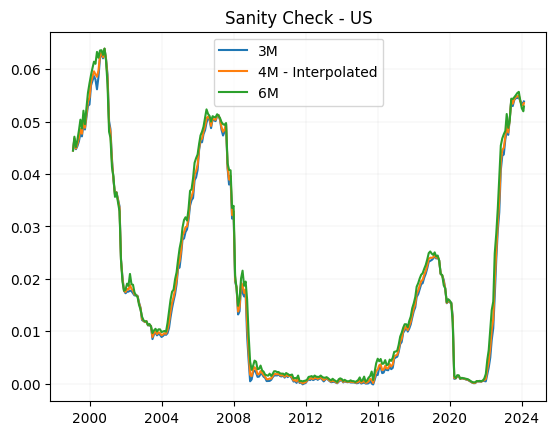

In [29]:
df = interpolate_yield(us_yield_df['Date'], us_yield_df, 4)

Y_m = df['Yearly Yield']

plt.plot(us_yield_df['Date'], us_yield_df['3M']/100)
plt.plot(us_yield_df['Date'], Y_m)
plt.plot(us_yield_df['Date'], us_yield_df['6M']/100)
plt.title('Sanity Check - US')
plt.legend(['3M', '4M - Interpolated', '6M'])
plt.grid(linewidth=0.1)

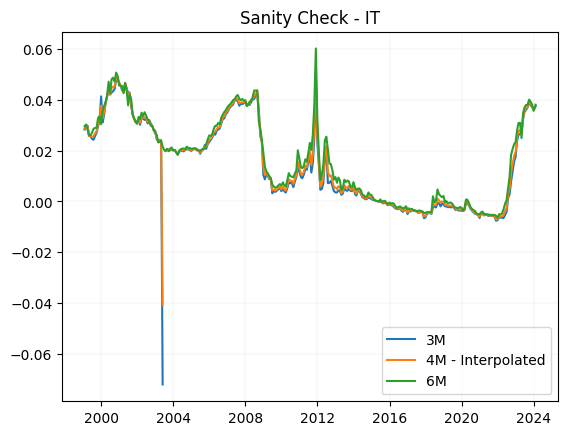

In [30]:
df = interpolate_yield(it_yield_df['Date'], it_yield_df, 4)

Y_m = df['Yearly Yield']

plt.plot(it_yield_df['Date'], it_yield_df['3M']/100)
plt.plot(it_yield_df['Date'], Y_m)
plt.plot(it_yield_df['Date'], it_yield_df['6M']/100)
plt.title('Sanity Check - IT')
plt.legend(['3M', '4M - Interpolated', '6M'])
plt.grid(linewidth=0.1)

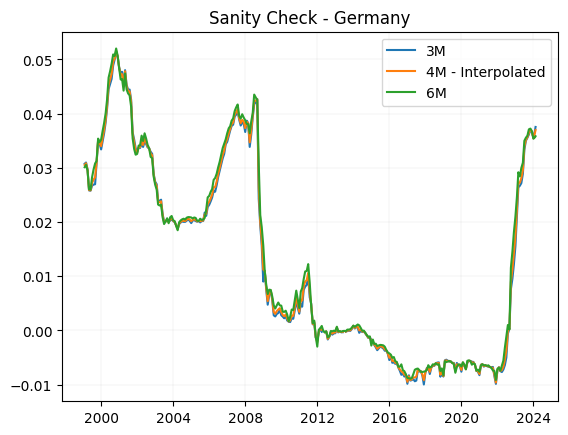

In [31]:
df = interpolate_yield(ger_yield_df['Date'], ger_yield_df, 4)

Y_m = df['Yearly Yield']

plt.plot(ger_yield_df['Date'], ger_yield_df['3M']/100)
plt.plot(ger_yield_df['Date'], Y_m)
plt.plot(ger_yield_df['Date'], ger_yield_df['6M']/100)
plt.title('Sanity Check - Germany')
plt.legend(['3M', '4M - Interpolated', '6M'])
plt.grid(linewidth=0.1)

### Compute the USD yield for Italy

In [32]:
def compute_USD_yield(m):
    
    # compute interpolated yields for each country (x,y,z) are the yearly rates...
    IT   = interpolate_yield(it_yield_df['Date'], it_yield_df, m)
    Y_it = IT['Monthly Yield']
    
    GER   = interpolate_yield(ger_yield_df['Date'], ger_yield_df, m)
    Y_ger = GER['Monthly Yield']
    
    US   = interpolate_yield(us_yield_df['Date'], us_yield_df, m)
    Y_us = US['Monthly Yield']
    
    # compute italian yield in USD
    Y_it_usd = (1+Y_it)*(1+Y_us)/(1+Y_ger) - 1
    
    new_df = pd.DataFrame({'Dates': it_yield_df['Date'], 'USD Monthly Yield': Y_it_usd})
    
    return new_df
    

In [33]:
compute_USD_yield(4)

,Dates,USD Monthly Yield
0,2024-02-08,0.004415
1,2024-01-31,0.004393
2,2023-12-31,0.004382
3,2023-11-30,0.004455
4,2023-10-31,0.004577
...,...,...
297,1999-05-31,0.003829
298,1999-04-30,0.003734
299,1999-03-31,0.003642
300,1999-02-28,0.003744


### Load Coupon calendar 

In [34]:
# Load cash flow calendar 
calendar = pd.read_excel('Cashflow_calendar.xlsx')

In [35]:
# Create 'Months to Maturity'
calendar['Months to Maturity'] = (pd.to_datetime(calendar['Maturity']) - pd.to_datetime(calendar['Issued'])).dt.days // 30

In [36]:
calendar

,ISIN,Issued,Maturity,Interest,Coupon,Principal,Coupon_1,Coupon_2,Coupon_3,Coupon_4,...,Coupon_52,Coupon_53,Coupon_54,Coupon_55,Coupon_56,Coupon_57,Coupon_58,Coupon_59,Unnamed: 65,Months to Maturity
0,US465410BN76,2005-01-21 00:00:00,1/21/2015,4.500,2.2500,100,2005-07-21,2006-01-21,2006-07-21,2007-01-21,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,121
1,US465410BQ08,1/25/2006,1/25/2016,4.750,2.3750,100,2006-07-25,2007-01-25,2007-07-25,2008-01-25,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,121
2,US465410BV92,1/26/2010,2015-07-26 00:00:00,3.125,1.5625,100,2010-07-26,2011-01-26,2011-07-26,2012-01-26,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,66
3,US465410BX58,10/17/2019,10/17/2024,2.375,1.1875,100,2020-04-17,2020-10-17,2021-04-17,2021-10-17,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,60
4,US465410BY32,10/17/2019,2029-10-17 00:00:00,2.875,1.4375,100,2020-04-17,2020-10-17,2021-04-17,2021-10-17,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,121
5,US465410BZ07,2019-10-17 00:00:00,2049-10-17 00:00:00,4.000,2.0000,100,2020-04-17,2020-10-17,2021-04-17,2021-10-17,...,2045-10-17,2046-04-17,2046-10-17,2047-04-17,2047-10-17,2048-04-17,2048-10-17,2049-04-17,NaT,365
6,US465410AZ16,10/25/2001,2006-10-25 00:00:00,4.375,2.1875,100,2002-04-25,2002-10-25,2003-04-25,2003-10-25,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,60
7,US465410BU10,10/5/2009,10/5/2012,2.125,1.0625,100,2010-04-05,2010-10-05,2011-04-05,2011-10-05,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,36
8,US465410BM93,6/30/2004,2007-12-14 00:00:00,3.750,1.8750,100,2004-12-14,2005-06-14,2005-12-14,2006-06-14,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,42
9,US465410AW84,2/22/2001,2011-02-22 00:00:00,6.000,3.0000,100,2001-08-22,2002-02-22,2002-08-22,2003-02-22,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,121


#### Test with one bond

In [37]:
# This function takes as an argument an ISIN, the calendar dataframe, and a specific date t. The print_option makes it easy
# for us to check manually a given bond
def hypothetical_price(ISIN, calendar, t, print_option):
    
    # Fix a bond using the ISIN provided 
    bond = calendar[calendar['ISIN']==ISIN]
    
    # Drop NaT (useless columns for this specific bond)
    bond = bond.dropna(axis=1)
    # Get useful information for that bond
    maturity = pd.to_datetime(bond['Maturity'].iloc[0])
    issuance = pd.to_datetime(bond['Issued'].iloc[0])
    coupon = bond['Coupon']
    
    
    if print_option==1:
        print('')
        print('Bond ISIN:                 ',ISIN)
        print('Bond Maturity is:          ',maturity.strftime('%Y-%m-%d'))
        print('Bond issuance is:          ',issuance.strftime('%Y-%m-%d'))
        print('Bond is being priced at:   ', pd.to_datetime(t).strftime('%Y-%m-%d'))
        print('Bond coupon is:            ',coupon.iloc[0])
        
    if t<issuance:
        print('')
        print("Date selected is earlier than this bond's issuance date")
        print('')
        price = 0
        return price
    
    if t>maturity:
        print('')
        print("Date selected is later than this bond's maturity date")
        print('')
        price = 0
        return price    
    
    
    # take the USD yield curve for Italy
    # check how long (in months) until maturity 
    m = (pd.to_datetime(bond['Maturity']).dt.to_period('M').iloc[0] - t.to_period('M')).n
    
    # compute the yield in USD
    yield_usd = compute_USD_yield(m)
    
    # take the USD yield for the date "t" 
    rate = yield_usd[yield_usd['Dates'].dt.to_period('M') == t.to_period('M')]['USD Monthly Yield'].iloc[0]
    
    # identify the columns referring to the coupon dates 
    coupon_columns = [col for col in bond.columns if (col.startswith('Coupon_'))]
    
    # condition to identify the outstanding coupons 
    A = [relativedelta(bond[col].iloc[0],t).years * 12 + relativedelta(bond[col].iloc[0],t).months>0 for col in bond.columns if (col.startswith('Coupon_'))]
    
    # generate the list of outstanding coupons 
    Coupon_list_outstanding = bond[coupon_columns].iloc[0][A]
    
    aux = 0
    
    if print_option==1:
        print(f'Yield used:                ', rate)
    
    delta_t_counter = 1;
    for c in Coupon_list_outstanding:
        
        delta_t = relativedelta(c, t).years*12 + relativedelta(c, t).months
        aux += coupon/(1+rate)**delta_t
        
        if print_option==1:
            print('')
            print(f"Time to maturity of coupon {c.strftime('%Y-%m-%d')} is       {delta_t} months")
            print(f"Discounted coupon          {c.strftime('%Y-%m-%d')} is {(coupon/(1+rate)**delta_t).iloc[0]}")
        
    
    time_to_maturity = relativedelta(maturity,t).years * 12  + relativedelta(maturity,t).months
    aux += 100/(1+rate)**(time_to_maturity)
    price = aux
    
    
    return price.iloc[0]
    
    
    

In [38]:
#t = pd.to_datetime('2011-07-16')
t = pd.to_datetime('2010-06-16')

In [39]:
hypothetical_price('US465410BW75', calendar, t,1)


Bond ISIN:                  US465410BW75
Bond Maturity is:           2013-09-16
Bond issuance is:           2010-09-16
Bond is being priced at:    2010-06-16
Bond coupon is:             1.0625

Date selected is earlier than this bond's issuance date



0

### Apply the above function for a list of ISINs

In [40]:
prices_at_t = np.empty(len(calendar['ISIN']))
for (i,isin) in enumerate(calendar['ISIN']):
    price = hypothetical_price(isin, calendar, t, 0)
    prices_at_t[i] = price


Date selected is earlier than this bond's issuance date


Date selected is earlier than this bond's issuance date


Date selected is earlier than this bond's issuance date


Date selected is later than this bond's maturity date


Date selected is later than this bond's maturity date


Date selected is later than this bond's maturity date


Date selected is later than this bond's maturity date


Date selected is later than this bond's maturity date


Date selected is earlier than this bond's issuance date


Date selected is earlier than this bond's issuance date


Date selected is later than this bond's maturity date


Date selected is later than this bond's maturity date


Date selected is earlier than this bond's issuance date



In [41]:
prices_at_t

array([105.21262268, 106.48763016,  97.77805101,   0.        ,
         0.        ,   0.        ,   0.        ,  99.17762126,
         0.        , 102.32301433,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        , 107.21528009,
         0.        , 104.3842131 , 103.06641138,  98.72802097,
         0.        ,   0.        ])